# Retrieving information about processing units of requests

In this example notebook we show how to retrieve **DownloadResponse** and **download headers** at the same time, which can be used to approximate the use of processing units.

The tutorial assumes knowledge of [Sentinel Hub Process API](https://github.com/sentinel-hub/sentinelhub-py/blob/master/examples/process_request.ipynb) and [Sentinel Hub Statistical API](https://github.com/sentinel-hub/sentinelhub-py/blob/master/examples/statistical_request.ipynb) examples.

For more information about the service please check the [official service documentation](https://docs.sentinel-hub.com/api/latest/api/process/).

In [1]:
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    SentinelHubStatistical,
    SHConfig,
    bbox_to_dimensions,
)

from utils import plot_image

config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! Please provide the credentials (OAuth client ID and client secret).")

Let's take the same bounding box of Betsiboka Estuary, used in Process API and Statistical API tutorial, to make a `DownloadResponse` request.

In [ ]:
betsiboka_coords_wgs84 = (46.16, -16.15, 46.51, -15.58)
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

## Sentinel Hub Request

In [3]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

The following will send the request to Sentinel Hub service and obtain results.

By default the data gets decoded to an image (or other requested data).

We can set `decode_data=False` in the `get_data` method in order to obtain the `Download Response` object with headers.

In [4]:
response = request_true_color.get_data(decode_data=False)
print(f"Response type: {type(response)}. List member type: {type(response[0])} ")

Response type: <class 'list'>. List member type: <class 'sentinelhub.download.models.DownloadResponse'> 


The response is a list with a single member, if we want to obtain the headers we can access it as: `response[0].headers`. We can display info on how many processing units a request used.

In [5]:
print("Response headers dictionary:")
[print(key, ":", value) for key, value in response[0].headers.items()]

print(f"\nProcessing units spent: {response[0].headers['x-processingunits-spent']}")

Response headers dictionary:
Date : Fri, 23 Sep 2022 08:55:22 GMT
Content-Type : image/png
Transfer-Encoding : chunked
Connection : keep-alive
access-control-allow-origin : *
access-control-allow-headers : origin,content-type,accept,accept-crs,authorization,cache-control
access-control-allow-credentials : true
access-control-allow-methods : GET, POST, PUT, DELETE, OPTIONS, HEAD, PATCH
access-control-max-age : 3600
x-processingunits-spent : 2.5202064514160156

Processing units spent: 2.5202064514160156


Responses obtained this way should be decoded by calling the `.decode()` method on them.

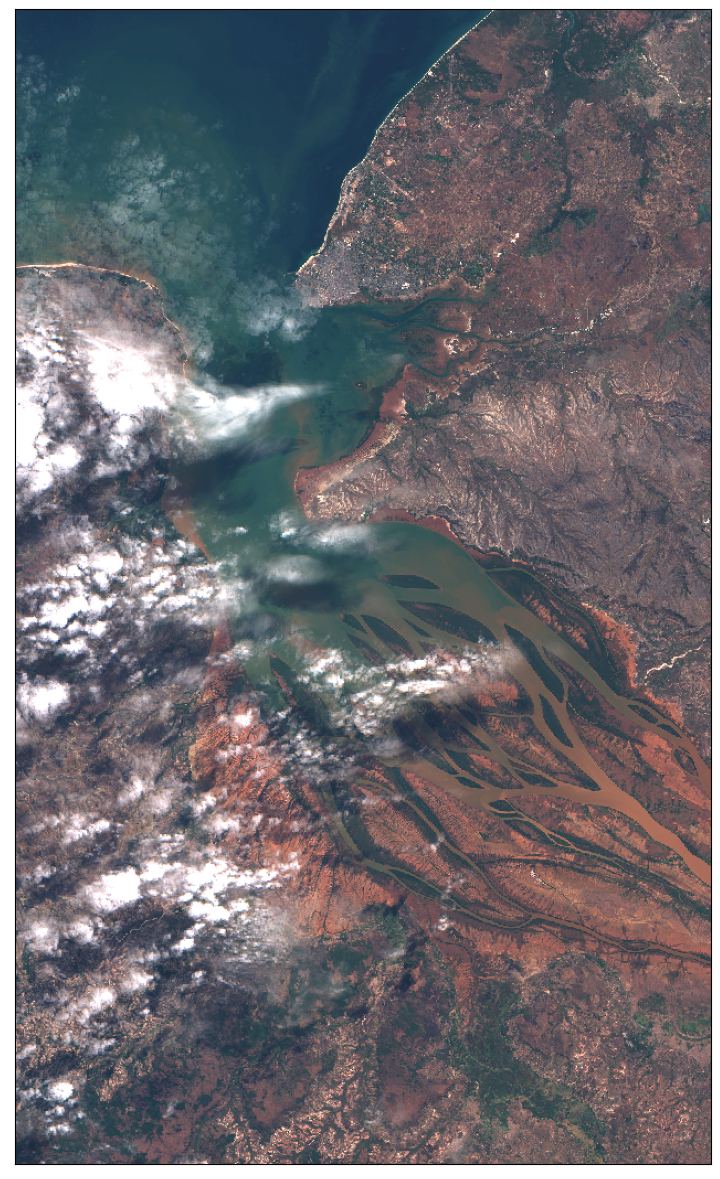

In [6]:
decoded_image = response[0].decode()
plot_image(decoded_image, factor=3.5 / 255, clip_range=(0, 1))

## Sentinel Hub Statistical

It is also possible to obtain response headers from Sentinel Hub Statistical. 

In [7]:
rgb_evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B02",
          "B03",
          "B04",
          "dataMask"
        ]
      }
    ],
    output: [
      {
        id: "rgb",
        bands: ["R", "G", "B"]
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}

function evaluatePixel(samples) {
    return {
      rgb: [samples.B04, samples.B03, samples.B02],
      dataMask: [samples.dataMask]
    };
}
"""

rgb_request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=rgb_evalscript,
        time_interval=("2020-06-07", "2020-06-13"),
        aggregation_interval="P1D",
        size=(631, 1047),
    ),
    input_data=[SentinelHubStatistical.input_data(DataCollection.SENTINEL2_L1C, maxcc=0.8)],
    bbox=betsiboka_bbox,
    config=config,
)

In [8]:
rgb_stats = rgb_request.get_data(decode_data=False)
print(f"Response type: {type(rgb_stats)}. List member type: {type(rgb_stats[0])} ")

Response type: <class 'list'>. List member type: <class 'sentinelhub.download.models.DownloadResponse'> 


In [9]:
print("Response headers dictionary:")
[print(key, ":", value) for key, value in rgb_stats[0].headers.items()]

print("\nProcessing units spent:", rgb_stats[0].headers["x-processingunits-spent"])

Response headers dictionary:
Date : Fri, 23 Sep 2022 08:55:34 GMT
Content-Type : application/json;charset=utf-8
Content-Length : 1188
Connection : keep-alive
access-control-allow-origin : *
access-control-allow-headers : origin,content-type,accept,accept-crs,authorization,cache-control
access-control-allow-credentials : true
access-control-allow-methods : GET, POST, PUT, DELETE, OPTIONS, HEAD, PATCH
access-control-max-age : 3600
x-processingunits-spent : 5.040412902832031

Processing units spent: 5.040412902832031


To get data out of the response, we again call the `.decode()` method on it.

In [11]:
%%time
rgb_stats[0].decode()

CPU times: user 57 µs, sys: 35 µs, total: 92 µs
Wall time: 99.7 µs


{'data': [{'interval': {'from': '2020-06-07T00:00:00Z',
    'to': '2020-06-08T00:00:00Z'},
   'outputs': {'rgb': {'bands': {'R': {'stats': {'min': 0.00419999985024333,
        'max': 0.7027999758720398,
        'mean': 0.1124257412122722,
        'stDev': 0.04222600867954154,
        'sampleCount': 660657,
        'noDataCount': 0}},
      'G': {'stats': {'min': 0.030400000512599945,
        'max': 0.5981000065803528,
        'mean': 0.09885213961499702,
        'stDev': 0.019804562978698967,
        'sampleCount': 660657,
        'noDataCount': 0}},
      'B': {'stats': {'min': 0.054999999701976776,
        'max': 0.5311999917030334,
        'mean': 0.10198085449414412,
        'stDev': 0.01494034416514153,
        'sampleCount': 660657,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2020-06-12T00:00:00Z', 'to': '2020-06-13T00:00:00Z'},
   'outputs': {'rgb': {'bands': {'R': {'stats': {'min': 0.004600000102072954,
        'max': 0.7160000205039978,
        'mean': 0.115467044